# Scenario discovery

In this part we use the method PRIM to find scenarios, which are likely to be the worst for our actor. Since we have to deal with two locations, we sometimes do the analysis twice.  
The scenario's are ran on the base case, so that is without any policy. The dataset will contain 50.000 scenario's, with the following outcome variables:
- External Costs
- RfR Costs
- Expected Number of Deaths
- Expected Annual Damage



In [162]:
# import the libaries
from ema_workbench import load_results
# from ema_workbench.analysis import parcoords
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from ema_workbench.analysis import prim
import numpy as np
from ema_workbench.util import ema_logging
from ema_workbench.analysis import pairs_plotting, prim

### 1. Explore the scenario runs 

In [163]:
# define filename. The file is saved in the same directory as the notebook.
input_filename = 'results/base_case'

# load the results
results = load_results(input_filename + '.tar.gz')

In [164]:
# split the results into experiments and outcomes
experiments, outcomes = results

# print the shape of the experiments
print('shape =', experiments.shape)

# display the head of the experiments
display(experiments.head())

shape = (50000, 53)


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,51,124.944949,1.5,0.965480,186.612558,1.5,0.361192,298.085251,1.0,0.690434,...,0,0,0,0,0,0,0,0,No Policy,dikesnet
1,21,221.109051,1.5,0.172842,126.656576,1.5,0.614823,184.312460,1.5,0.323419,...,0,0,0,0,0,0,0,1,No Policy,dikesnet
2,131,207.887019,10.0,0.353144,338.832903,10.0,0.165925,329.104042,10.0,0.940157,...,0,0,0,0,0,0,0,2,No Policy,dikesnet
3,93,315.490331,1.5,0.313171,317.617281,1.5,0.397788,231.794434,1.5,0.210204,...,0,0,0,0,0,0,0,3,No Policy,dikesnet
4,82,293.111014,1.5,0.699879,305.636300,1.0,0.471546,214.687587,10.0,0.327454,...,0,0,0,0,0,0,0,4,No Policy,dikesnet


In [165]:
# load the basecase results
df_base = pd.read_csv("results/base_case_results.csv", index_col=0)
# df_base.drop(columns=["Unnamed: 0"],inplace=True)
df_base.head()

,A.1_External Costs,A.1RfR Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2RfR Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,A.0_ID flood wave shape,A.1_Bmax,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,0,0,1.990222,3.454818e+09,0,0,0.492564,6.994367e+08,113,252.718961,...,0,0,0,0,0,0,0,50000,No Policy,dikesnet
1,0,0,1.463519,1.867800e+09,0,0,0.000000,0.000000e+00,80,50.642090,...,0,0,0,0,0,0,0,50001,No Policy,dikesnet
2,0,0,0.000000,0.000000e+00,0,0,0.048993,4.863105e+07,70,185.689285,...,0,0,0,0,0,0,0,50002,No Policy,dikesnet
3,0,0,0.000000,0.000000e+00,0,0,0.048675,5.361463e+07,125,282.936950,...,0,0,0,0,0,0,0,50003,No Policy,dikesnet
4,0,0,0.117940,2.054032e+08,0,0,0.146582,1.967625e+08,118,333.445701,...,0,0,0,0,0,0,0,50004,No Policy,dikesnet


In [166]:
# print the columns of the basecase results
df_base.columns

Index(['A.1_External Costs', 'A.1RfR Costs', 'A.1_Expected Number of Deaths',
       'A.1_Expected Annual Damage', 'A.2_External Costs', 'A.2RfR Costs',
       'A.2_Expected Number of Deaths', 'A.2_Expected Annual Damage',
       'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',

In [167]:
# Our objectives are the following: External Costs, RfR Costs, Expected Number of Deaths, Expected Annual Damage
# Per location, so times 2. 

# Make a dataframe with the outcomes
df_outcomes = pd.DataFrame(outcomes)
df_outcomes

,A.1_External Costs,A.1_RfR Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_RfR Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage
0,0,0,0.000000,0.000000e+00,0,0,0.102270,1.285213e+08
1,0,0,1.515402,2.057940e+09,0,0,0.000000,0.000000e+00
2,0,0,1.466953,2.122853e+09,0,0,0.081071,9.001870e+07
3,0,0,1.536291,2.120436e+09,0,0,0.000000,0.000000e+00
4,0,0,0.032005,4.698537e+07,0,0,0.084541,9.525426e+07
...,...,...,...,...,...,...,...,...
49995,0,0,0.032769,4.572404e+07,0,0,0.033297,3.457147e+07
49996,0,0,0.001158,1.687636e+06,0,0,0.052262,5.817448e+07
49997,0,0,0.000198,3.050305e+05,0,0,0.073482,8.748160e+07
49998,0,0,1.531159,2.075030e+09,0,0,0.000000,0.000000e+00


In [168]:
# So, as can be seen, External and RfR Costs are the same for all locations. Namely, zero. 
df_outcomes.nunique()

A.1_External Costs                   1
A.1_RfR Costs                        1
A.1_Expected Number of Deaths     3277
A.1_Expected Annual Damage       20379
A.2_External Costs                   1
A.2_RfR Costs                        1
A.2_Expected Number of Deaths    23446
A.2_Expected Annual Damage       34144
dtype: int64

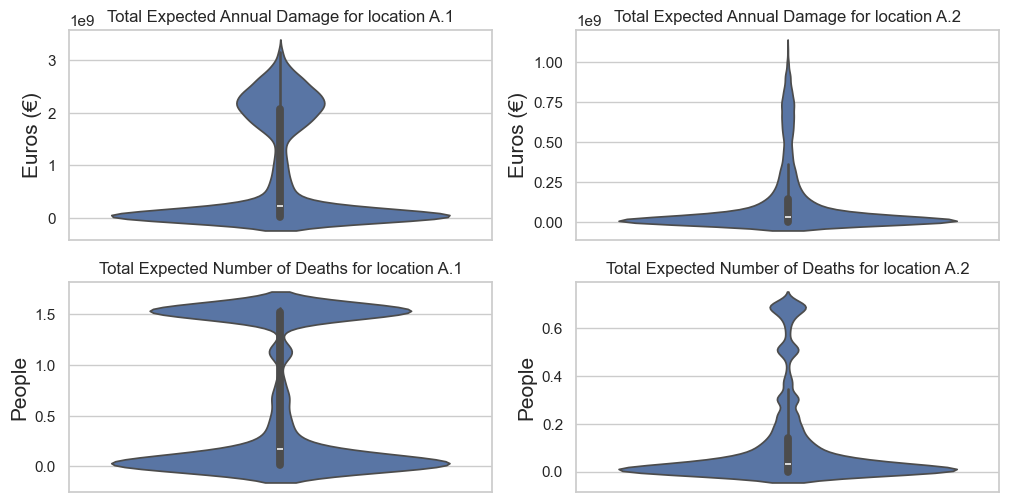

In [169]:
# #First we are going to look at the totals

# plotting the number of deaths and the damage costs (aggregated over time and location)
f, axes = plt.subplots(2, 2, figsize=(12,6))
sns.set(style="whitegrid", font_scale=1)
plt.rcParams["axes.labelsize"] = 15

sns.violinplot(data=df_outcomes["A.1_Expected Annual Damage"], ax=axes[0, 0])
sns.violinplot(data=df_outcomes["A.2_Expected Annual Damage"], ax=axes[0, 1])
sns.violinplot(data=df_outcomes["A.1_Expected Number of Deaths"], ax=axes[1, 0])
sns.violinplot(data=df_outcomes["A.2_Expected Number of Deaths"], ax=axes[1, 1])

#layout of the plots
axes[0, 0].set_title("Total Expected Annual Damage for location A.1")
axes[0, 0].set_ylabel('Euros (€)')
axes[0, 0].set(xticklabels = [])

axes[0, 1].set_title("Total Expected Annual Damage for location A.2")
axes[0, 1].set_ylabel('Euros (€)')
axes[0, 1].set(xticklabels = [])

axes[1, 0].set_title("Total Expected Number of Deaths for location A.1")
axes[1, 0].set_ylabel('People')
axes[1, 0].set(xticklabels = [])

axes[1, 1].set_title("Total Expected Number of Deaths for location A.2")
axes[1, 1].set_ylabel('People')
axes[1, 1].set(xticklabels = [])

plt.show()
# axes[1].set_ylabel('Euros (€)')
# axes[1].set(xticklabels = [])

# axes[2].set_title("Total Expected Number of Deaths for location A.1")
# axes[2].set_ylabel('People')
# axes[2].set(xticklabels = [])

# axes[3].set_title("Total Expected Number of Deaths for location A.2")
# axes[3].set_ylabel('People')
# axes[3].set(xticklabels = [])

# plt.show()

In [170]:
# The outcomes of interest are all columns in df_outcomes.
outcomes_of_interest = list(df_outcomes.columns)

# Split the outcomes of interest into the different location
outcomes_of_interest_A1 = [i for i in outcomes_of_interest if 'A.1' in i]
outcomes_of_interest_A2 = [i for i in outcomes_of_interest if 'A.2' in i]

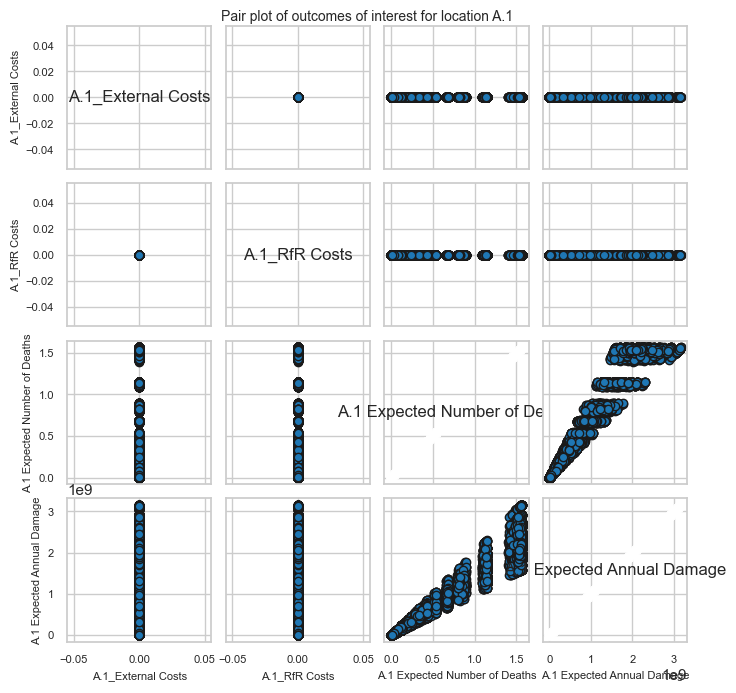

In [171]:
# Create subset of outcomes of interest for location A.1
outcomes_subset = {k:outcomes[k] for k in outcomes_of_interest_A1 if k in outcomes}

# Rename data columns for readability
ylabels = {
    'A.1_External Costs' : 'A.1_External Costs',
    'A.1_Expected Number of Deaths' : 'A.1 Expected Number of Deaths',
    'A.1_Expected Annual Damage' : 'A.1 Expected Annual Damage',
    'A.1_RfR Costs' : 'A.1_RfR Costs',
    # 'A.2_External Costs' : 'A.2_External Costs',
    # 'A.2_Expected Number of Deaths' : 'A.2 Expected Number of Deaths',
    # 'A.2_Expected Annual Damage' : 'A.2 Expected Annual Damage',
    # 'A.2RfR Total Costs' : 'A.2RfR Total Costs',
}

# Create a pair plot of the outcomes of interest of location A.1
fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes_subset, group_by="policy", legend=False, ylabels=ylabels)
fig.set_size_inches(8, 8)

for ax in axes.values():
    ax.tick_params(axis='both', which='major', labelsize=8)  # Set the font size of the tick labels
    ax.xaxis.label.set_size(8)  # Set the font size of the x-axis labels
    ax.yaxis.label.set_size(8)  # Set the font size of the y-axis labels

fig.suptitle("Pair plot of outcomes of interest for location A.1", fontsize=10, y=0.9)
# plt.savefig('imgages/scenario_discovery_outcomes_A1_pairplot.png')
plt.show()

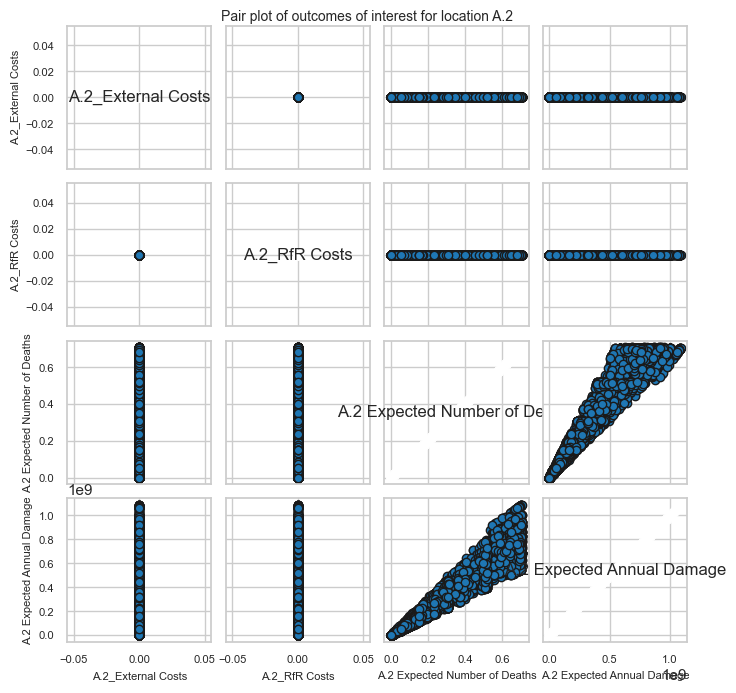

In [172]:
# Create subset of outcomes of interest for location A.2
outcomes_subset = {k:outcomes[k] for k in outcomes_of_interest_A2 if k in outcomes}

# Rename data columns for readability
ylabels = {
    # 'A.1_External Costs' : 'A.1_External Costs',
    # 'A.1_Expected Number of Deaths' : 'A.1 Expected Number of Deaths',
    # 'A.1_Expected Annual Damage' : 'A.1 Expected Annual Damage',
    # 'A.1_RfR Costs' : 'A.1_RfR Costs',
    'A.2_External Costs' : 'A.2_External Costs',
    'A.2_Expected Number of Deaths' : 'A.2 Expected Number of Deaths',
    'A.2_Expected Annual Damage' : 'A.2 Expected Annual Damage',
    'A.2_RfR Costs' : 'A.2_RfR Costs',
}

# Create a pair plot of the outcomes of interest of location A.1
fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes_subset, group_by="policy", legend=False, ylabels=ylabels)
fig.set_size_inches(8, 8)

for ax in axes.values():
    ax.tick_params(axis='both', which='major', labelsize=8)  # Set the font size of the tick labels
    ax.xaxis.label.set_size(8)  # Set the font size of the x-axis labels
    ax.yaxis.label.set_size(8)  # Set the font size of the y-axis labels

fig.suptitle("Pair plot of outcomes of interest for location A.2", fontsize=10, y=0.9)
# plt.savefig('imgages/scenario_discovery_outcomes_A2_pairplot.png')
plt.show()

So, conclusions which can be made for both locations are:

- External costs are always 0.
- RfR costs are always 0.
- Both is logical, since in the base case, without any policy, there will not be any External costs (Expected Evacuation Costs and Dike Investment Costs) or RfR costs. 
- Expected number of Deaths and Expected Annual Damage are decently strong correlated. Which actually makes sense.
- Difference is mainly the gradation of numbers. For location A2 the range of figures of expected annual damage and expected number of deaths are significantly lower than for location A1.

### Experiments

In [173]:
experiments_sliced = experiments.iloc[:,:19]
experiments_sliced

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,51,124.944949,1.5,0.965480,186.612558,1.5,0.361192,298.085251,1.0,0.690434,335.202711,10.0,0.197244,44.934875,1.5,0.928058,1.5,1.5,3.5
1,21,221.109051,1.5,0.172842,126.656576,1.5,0.614823,184.312460,1.5,0.323419,274.533484,1.0,0.860717,270.590253,1.0,0.058684,1.5,4.5,4.5
2,131,207.887019,10.0,0.353144,338.832903,10.0,0.165925,329.104042,10.0,0.940157,152.659419,1.0,0.867790,72.352163,10.0,0.029257,2.5,3.5,2.5
3,93,315.490331,1.5,0.313171,317.617281,1.5,0.397788,231.794434,1.5,0.210204,34.673513,1.5,0.081300,118.053353,1.0,0.285650,2.5,4.5,2.5
4,82,293.111014,1.5,0.699879,305.636300,1.0,0.471546,214.687587,10.0,0.327454,288.279890,1.0,0.527409,167.064316,1.0,0.648632,3.5,2.5,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,62,321.616643,1.5,0.724065,71.881936,10.0,0.690810,348.476106,1.5,0.564494,73.173805,1.5,0.792240,250.531944,10.0,0.788202,4.5,1.5,2.5
49996,36,314.197104,1.5,0.790554,78.448640,1.0,0.535387,190.467088,1.5,0.478701,88.545218,1.0,0.321918,215.959007,1.0,0.324620,1.5,2.5,3.5
49997,30,113.594422,1.0,0.840008,175.576458,1.0,0.509296,299.492845,1.0,0.710544,235.318213,1.0,0.870422,307.847717,10.0,0.862621,2.5,2.5,1.5
49998,55,334.081152,1.0,0.318638,298.865589,1.5,0.614740,144.360129,10.0,0.886877,67.236182,1.5,0.814070,190.160572,1.0,0.609990,1.5,4.5,4.5


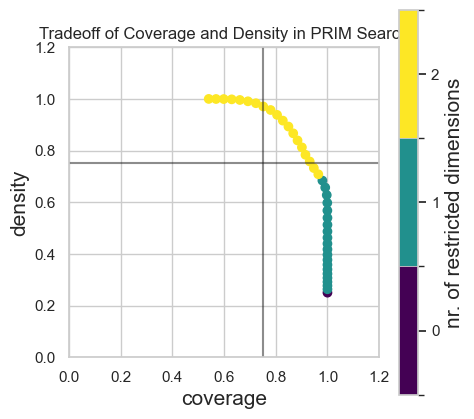

In [174]:
# uncertainties = experiments.columns.tolist()
# ooi = 'A.2_Expected Annual Damage'
# performance_threshold = np.percentile(df_outcomes[ooi], 75)
# prim_alg = prim.setup_prim(results,
#                            classify=lambda y: y[ooi] > performance_threshold,
#                            threshold=0.75,
#                            incl_unc=uncertainties,
#                            mass_min=0.01
#                            )
# box1 = prim_alg.find_box()
# box1.show_tradeoff()

# plt.hlines(y=[0.75], xmin=0, xmax=1.2, colors='k', alpha=0.5)
# plt.vlines(x=[0.75], ymin=0, ymax=1.2, colors='k', alpha=0.5)
# plt.title('Tradeoff of Coverage and Density in PRIM Search')
# # plt.savefig('img/scenario_discovery__prim_trajectory.png')
# plt.show()

In [92]:
box1.peeling_trajectory

,coverage,density,id,mass,mean,res_dim
0,1.00000,0.250000,0,1.00000,0.250000,0
1,1.00000,0.263158,1,0.95000,0.263158,1
2,1.00000,0.277008,2,0.90250,0.277008,1
3,1.00000,0.291593,3,0.85736,0.291593,1
4,1.00000,0.306944,4,0.81448,0.306944,1
5,1.00000,0.323106,5,0.77374,0.323106,1
6,1.00000,0.340118,6,0.73504,0.340118,1
7,1.00000,0.358023,7,0.69828,0.358023,1
8,1.00000,0.376869,8,0.66336,0.376869,1
9,1.00000,0.396712,9,0.63018,0.396712,1


In [93]:
candidates = box1.peeling_trajectory
candidates = candidates[(candidates.coverage > 0.75)
                         & (candidates.density > 0.75)]
candidates

,coverage,density,id,mass,mean,res_dim
23,0.93136,0.757893,23,0.30722,0.757893,2
24,0.91488,0.783717,24,0.29184,0.783717,2
25,0.90104,0.812509,25,0.27724,0.812509,2
26,0.88416,0.839307,26,0.26336,0.839307,2
27,0.86744,0.866816,27,0.25018,0.866816,2
28,0.84896,0.893040,28,0.23766,0.893040,2
29,0.82720,0.916017,29,0.22576,0.916017,2
30,0.80488,0.938264,30,0.21446,0.938264,2
31,0.77992,0.957098,31,0.20372,0.957098,2
32,0.75144,0.970752,32,0.19352,0.970752,2


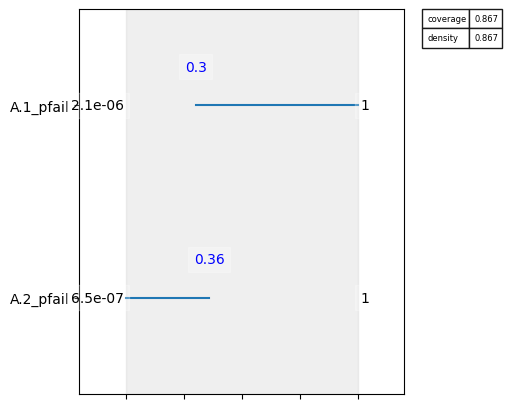

In [94]:
box1.inspect(27, style='graph', ticklabel_formatter='{}', boxlim_formatter='{:.2g}')
# box1.inspect(5)
#plt.savefig("PRIM_boxinspect_scenarios")
plt.show()

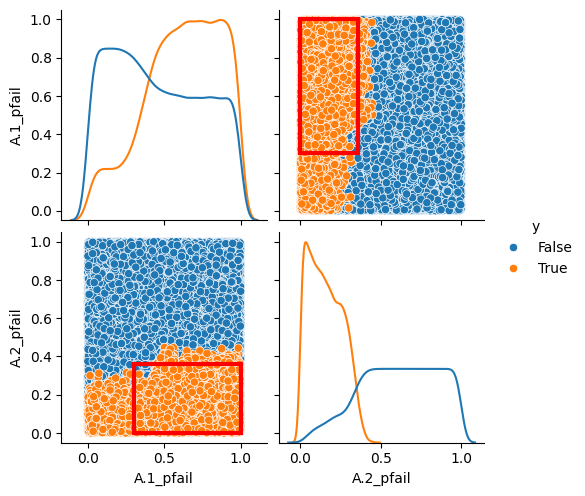

In [95]:
box1.show_pairs_scatter(27)
plt.show()

In [145]:
df_outcomes

,A.1_External Costs,A.1_RfR Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_RfR Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage
0,0,0,0.000000,0.000000e+00,0,0,0.102270,1.285213e+08
1,0,0,1.515402,2.057940e+09,0,0,0.000000,0.000000e+00
2,0,0,1.466953,2.122853e+09,0,0,0.081071,9.001870e+07
3,0,0,1.536291,2.120436e+09,0,0,0.000000,0.000000e+00
4,0,0,0.032005,4.698537e+07,0,0,0.084541,9.525426e+07
...,...,...,...,...,...,...,...,...
49995,0,0,0.032769,4.572404e+07,0,0,0.033297,3.457147e+07
49996,0,0,0.001158,1.687636e+06,0,0,0.052262,5.817448e+07
49997,0,0,0.000198,3.050305e+05,0,0,0.073482,8.748160e+07
49998,0,0,1.531159,2.075030e+09,0,0,0.000000,0.000000e+00


In [160]:
experiments_sliced

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,51,124.944949,1.5,0.965480,186.612558,1.5,0.361192,298.085251,1.0,0.690434,335.202711,10.0,0.197244,44.934875,1.5,0.928058,1.5,1.5,3.5
1,21,221.109051,1.5,0.172842,126.656576,1.5,0.614823,184.312460,1.5,0.323419,274.533484,1.0,0.860717,270.590253,1.0,0.058684,1.5,4.5,4.5
2,131,207.887019,10.0,0.353144,338.832903,10.0,0.165925,329.104042,10.0,0.940157,152.659419,1.0,0.867790,72.352163,10.0,0.029257,2.5,3.5,2.5
3,93,315.490331,1.5,0.313171,317.617281,1.5,0.397788,231.794434,1.5,0.210204,34.673513,1.5,0.081300,118.053353,1.0,0.285650,2.5,4.5,2.5
4,82,293.111014,1.5,0.699879,305.636300,1.0,0.471546,214.687587,10.0,0.327454,288.279890,1.0,0.527409,167.064316,1.0,0.648632,3.5,2.5,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,62,321.616643,1.5,0.724065,71.881936,10.0,0.690810,348.476106,1.5,0.564494,73.173805,1.5,0.792240,250.531944,10.0,0.788202,4.5,1.5,2.5
49996,36,314.197104,1.5,0.790554,78.448640,1.0,0.535387,190.467088,1.5,0.478701,88.545218,1.0,0.321918,215.959007,1.0,0.324620,1.5,2.5,3.5
49997,30,113.594422,1.0,0.840008,175.576458,1.0,0.509296,299.492845,1.0,0.710544,235.318213,1.0,0.870422,307.847717,10.0,0.862621,2.5,2.5,1.5
49998,55,334.081152,1.0,0.318638,298.865589,1.5,0.614740,144.360129,10.0,0.886877,67.236182,1.5,0.814070,190.160572,1.0,0.609990,1.5,4.5,4.5


In [156]:
df_outcomes[outcomes_of_interest]

,A.1_External Costs,A.1_RfR Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_RfR Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage
0,0,0,0.000000,0.000000e+00,0,0,0.102270,1.285213e+08
1,0,0,1.515402,2.057940e+09,0,0,0.000000,0.000000e+00
2,0,0,1.466953,2.122853e+09,0,0,0.081071,9.001870e+07
3,0,0,1.536291,2.120436e+09,0,0,0.000000,0.000000e+00
4,0,0,0.032005,4.698537e+07,0,0,0.084541,9.525426e+07
...,...,...,...,...,...,...,...,...
49995,0,0,0.032769,4.572404e+07,0,0,0.033297,3.457147e+07
49996,0,0,0.001158,1.687636e+06,0,0,0.052262,5.817448e+07
49997,0,0,0.000198,3.050305e+05,0,0,0.073482,8.748160e+07
49998,0,0,1.531159,2.075030e+09,0,0,0.000000,0.000000e+00


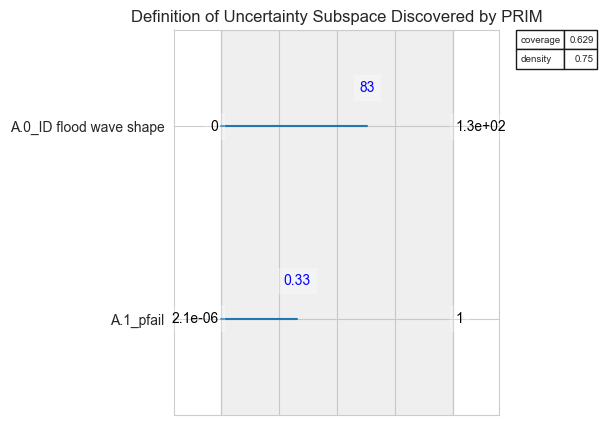

In [230]:
box1.select(7)
box1.inspect(style="graph", ticklabel_formatter='{}', boxlim_formatter='{:.2g}')
plt.title('Definition of Uncertainty Subspace Discovered by PRIM')
# plt.savefig('img/scenario_discovery__prim_boundary.png')
plt.show()

In [ ]:
### To find the threshold

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from ema_workbench.analysis import prim

# percentile_deaths = np.percentile(df_outcomes["A.1_Expected Number of Deaths"], 75)

# # Bool the values if they are larger than the threshold
# selval = pd.DataFrame()
# selval["Death25p"] = df_outcomes["A.1_Expected Number of Deaths"] > percentile_deaths

# # If cost and deaths are in the 75th upper percentiles indicate true
# y1 = selval["Death25p"] 

# # List to store results
# boxes = []
# thresholds = np.arange(0.5, 0.95, 0.05)

# for threshold in thresholds:
#     prim_alg = prim.Prim(experiments_sliced, y1, threshold=threshold, peel_alpha=0.2)
#     box = prim_alg.find_box()
#     boxes.append((threshold, box))

# plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams["figure.figsize"] = (12, 8)

# # Plot trade-offs for different thresholds
# for threshold, box in boxes:
#     print(f'Threshold {threshold:.2f}:')
#     box.show_tradeoff()

# plt.legend()
# plt.show()


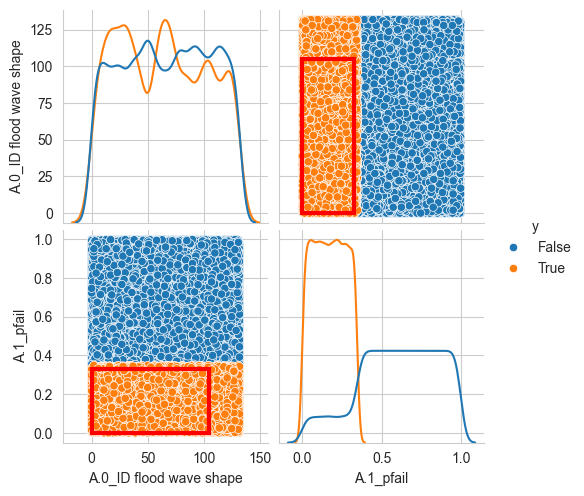

In [227]:
box1.show_pairs_scatter()
# show_pairs_scatter doesn't give enough vertical space to show suptitle
# plt.suptitle('Classified Scenario Runs by Key Uncertainty Values'
#              'with PRIM Box Superimposed', y=0.97)
# plt.savefig('img/scenario_discovery__prim_pairs_scatter.png')
plt.show()

In [233]:
experiments_sliced['A.0_ID flood wave shape'].value_counts()

A.0_ID flood wave shape
91    377
57    377
30    377
9     377
96    377
     ... 
47    375
58    375
41    375
81    375
43    375
Name: count, Length: 133, dtype: int64

In [236]:
df_outcomes

,A.1_External Costs,A.1_RfR Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_RfR Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage
0,0,0,0.000000,0.000000e+00,0,0,0.102270,1.285213e+08
1,0,0,1.515402,2.057940e+09,0,0,0.000000,0.000000e+00
2,0,0,1.466953,2.122853e+09,0,0,0.081071,9.001870e+07
3,0,0,1.536291,2.120436e+09,0,0,0.000000,0.000000e+00
4,0,0,0.032005,4.698537e+07,0,0,0.084541,9.525426e+07
...,...,...,...,...,...,...,...,...
49995,0,0,0.032769,4.572404e+07,0,0,0.033297,3.457147e+07
49996,0,0,0.001158,1.687636e+06,0,0,0.052262,5.817448e+07
49997,0,0,0.000198,3.050305e+05,0,0,0.073482,8.748160e+07
49998,0,0,1.531159,2.075030e+09,0,0,0.000000,0.000000e+00


In [259]:
df_outcomes[['A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths']]
print(percentile_deaths_A1)

1.5289632082175042


,Death25p,Costs25p
0,False,False
1,False,False
2,False,True
3,True,True
4,False,False
...,...,...
49995,False,False
49996,False,False
49997,False,False
49998,True,True


---


False    40978
True      9022
Name: count, dtype: int64

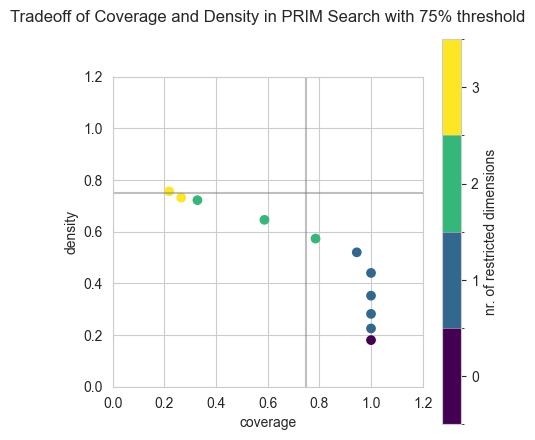

In [266]:
# df_outcomes['A.1_Expected Number of Deaths'] > 0.01

# Setting the upper 25% range for the total number of deaths and  damage costs 

percentile_deaths_A1 = np.percentile(df_outcomes["A.1_Expected Number of Deaths"], 75)
percentile_costs_A1 = np.percentile(df_outcomes["A.1_Expected Annual Damage"], 75)

# Bool the values if they are larger than the threshold
selval = pd.DataFrame()
selval["Death25p"] = df_outcomes["A.1_Expected Number of Deaths"] > percentile_deaths_A1
selval["Costs25p"] = df_outcomes["A.1_Expected Annual Damage"] > percentile_costs_A1

# If cost and deaths are in the 75th upper percentiles indicate true
y1 = selval["Death25p"] & selval["Costs25p"]
display(selval)
print('---')
display(y1.value_counts())
# y1.to_csv('./worst_scenarios_PRIM.csv')

# Execute prim algorithm
# We select the value for peel_alpha by trial and error such that we get all the dimensions as output 
# as well as a threshold above 0.65
prim_alg = prim.Prim(experiments_sliced, y1, threshold=0.75, peel_alpha=0.2)
box1 = prim_alg.find_box()

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (5,5)

sns.set_style('whitegrid')

# Show trade off plot
box1.show_tradeoff()
plt.hlines(y=[0.75], xmin=0, xmax=1.2, colors='grey', alpha=0.5)
plt.vlines(x=[0.75], ymin=0, ymax=1.2, colors='grey', alpha=0.5)
plt.title('Tradeoff of Coverage and Density in PRIM Search with 75% threshold', y=1.15)

#plt.savefig("PRIM_tradeoff_scenarios")
plt.show()

In [245]:
box1.peeling_trajectory

,coverage,density,id,mass,mean,res_dim
0,1.000000,0.180440,0,1.00000,0.180440,0
1,1.000000,0.200489,1,0.90000,0.200489,1
2,1.000000,0.222765,2,0.81000,0.222765,1
3,1.000000,0.247517,3,0.72900,0.247517,1
4,1.000000,0.275019,4,0.65610,0.275019,1
5,1.000000,0.305582,5,0.59048,0.305582,1
6,1.000000,0.339543,6,0.53142,0.339543,1
7,1.000000,0.377284,7,0.47826,0.377284,1
8,1.000000,0.419218,8,0.43042,0.419218,1
9,1.000000,0.465820,9,0.38736,0.465820,1


In [246]:
box1.select(12)

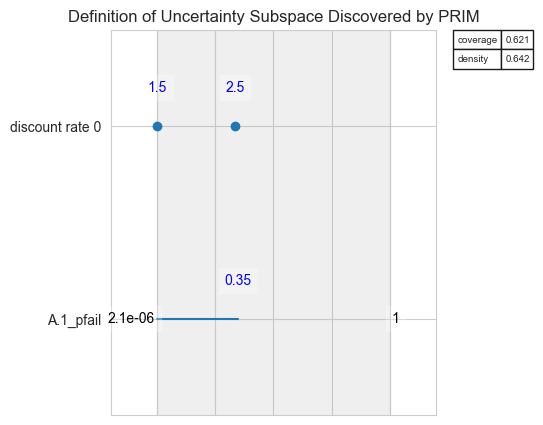

In [248]:
box1.select(12)
box1.inspect(style="graph", ticklabel_formatter='{}', boxlim_formatter='{:.2g}')
plt.title('Definition of Uncertainty Subspace Discovered by PRIM')
# plt.savefig('img/scenario_discovery__prim_boundary.png')
plt.show()

c:\Users\pepij\anaconda3\envs\MBDM\lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


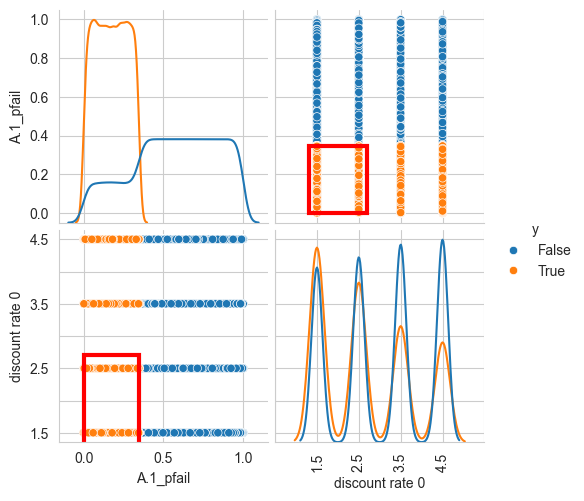

In [249]:
box1.show_pairs_scatter()
# show_pairs_scatter doesn't give enough vertical space to show suptitle
# plt.suptitle('Classified Scenario Runs by Key Uncertainty Values'
#              'with PRIM Box Superimposed', y=0.97)
# plt.savefig('img/scenario_discovery__prim_pairs_scatter.png')
plt.show()

percentile_deaths_A2: 0.5071101132433944
percentile_costs_A2: 529142731.8578895


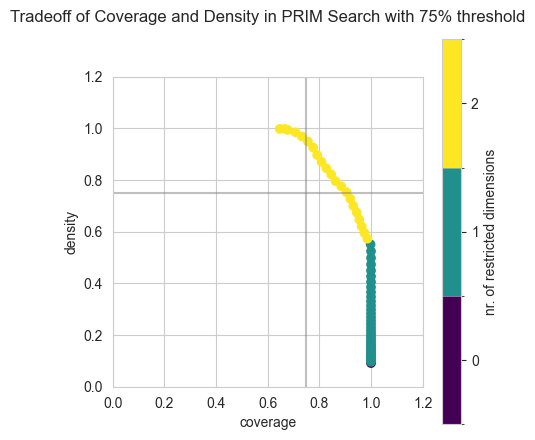

In [267]:
# df_outcomes['A.1_Expected Number of Deaths'] > 0.01

# Setting the upper 25% range for the total number of deaths and  damage costs 

percentile_deaths_A2 = np.percentile(df_outcomes["A.2_Expected Number of Deaths"], 90)
percentile_costs_A2 = np.percentile(df_outcomes["A.2_Expected Annual Damage"], 90)

print('percentile_deaths_A2:', percentile_deaths_A2)
print('percentile_costs_A2:', percentile_costs_A2)

# Bool the values if they are larger than the threshold
selval2 = pd.DataFrame()
selval2["Death25p"] = df_outcomes["A.2_Expected Number of Deaths"] > percentile_deaths_A2
selval2["Costs25p"] = df_outcomes["A.2_Expected Annual Damage"] > percentile_costs_A2

# If cost and deaths are in the 75th upper percentiles indicate true
y2 = selval2["Death25p"] & selval2["Costs25p"]
# y1.to_csv('./worst_scenarios_PRIM.csv')

# Execute prim algorithm
# We select the value for peel_alpha by trial and error such that we get all the dimensions as output 
# as well as a threshold above 0.65
prim_alg = prim.Prim(experiments_sliced, y2, threshold=0.90, peel_alpha=0.05)
box1 = prim_alg.find_box()

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (5,5)

sns.set_style('whitegrid')

# Show trade off plot
box1.show_tradeoff()
plt.hlines(y=[0.75], xmin=0, xmax=1.2, colors='grey', alpha=0.5)
plt.vlines(x=[0.75], ymin=0, ymax=1.2, colors='grey', alpha=0.5)
plt.title('Tradeoff of Coverage and Density in PRIM Search with 75% threshold', y=1.15)

#plt.savefig("PRIM_tradeoff_scenarios")
plt.show()

In [255]:
box1.peeling_trajectory

,coverage,density,id,mass,mean,res_dim
0,1.000000,0.091600,0,1.00000,0.091600,0
1,1.000000,0.096421,1,0.95000,0.096421,1
2,1.000000,0.101496,2,0.90250,0.101496,1
3,1.000000,0.106840,3,0.85736,0.106840,1
4,1.000000,0.112464,4,0.81448,0.112464,1
5,1.000000,0.118386,5,0.77374,0.118386,1
6,1.000000,0.124619,6,0.73504,0.124619,1
7,1.000000,0.131179,7,0.69828,0.131179,1
8,1.000000,0.138085,8,0.66336,0.138085,1
9,1.000000,0.145355,9,0.63018,0.145355,1


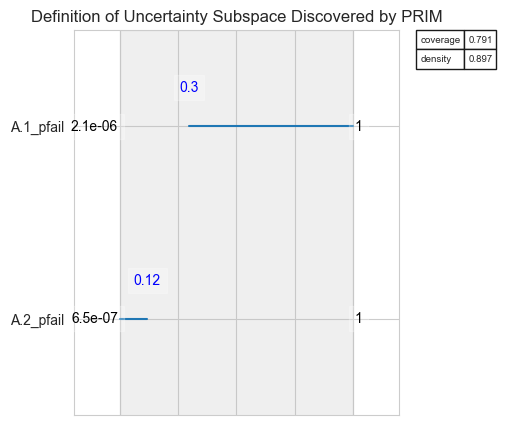

In [256]:
box1.select(49)
box1.inspect(style="graph", ticklabel_formatter='{}', boxlim_formatter='{:.2g}')
plt.title('Definition of Uncertainty Subspace Discovered by PRIM')
# plt.savefig('img/scenario_discovery__prim_boundary.png')
plt.show()

In [ ]:
# df_outcomes['A.1_Expected Number of Deaths'] > 0.01

# Setting the upper 25% range for the total number of deaths and  damage costs 

percentile_deaths_A2 = np.percentile(df_outcomes["A.1_Expected Number of Deaths"] + df_outcomes[""], 90)
percentile_costs_A2 = np.percentile(df_outcomes["A.2_Expected Number of Deaths"], 90)

print('percentile_deaths_A2:', percentile_deaths_A2)
print('percentile_costs_A2:', percentile_costs_A2)

# Bool the values if they are larger than the threshold
selval2 = pd.DataFrame()
selval2["Death25p"] = df_outcomes["A.2_Expected Number of Deaths"] > percentile_deaths_A2
selval2["Costs25p"] = df_outcomes["A.2_Expected Annual Damage"] > percentile_costs_A2

# If cost and deaths are in the 75th upper percentiles indicate true
y2 = selval2["Death25p"] & selval2["Costs25p"]
# y1.to_csv('./worst_scenarios_PRIM.csv')

# Execute prim algorithm
# We select the value for peel_alpha by trial and error such that we get all the dimensions as output 
# as well as a threshold above 0.65
prim_alg = prim.Prim(experiments_sliced, y2, threshold=0.90, peel_alpha=0.05)
box1 = prim_alg.find_box()

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (5,5)

sns.set_style('whitegrid')

# Show trade off plot
box1.show_tradeoff()
plt.hlines(y=[0.75], xmin=0, xmax=1.2, colors='grey', alpha=0.5)
plt.vlines(x=[0.75], ymin=0, ymax=1.2, colors='grey', alpha=0.5)
plt.title('Tradeoff of Coverage and Density in PRIM Search with 75% threshold', y=1.15)

#plt.savefig("PRIM_tradeoff_scenarios")
plt.show()